# Lab 8
Author: Yunting Chiu

Mail: yc6705a@american.edu

In [9]:
# install the library
library(tidyverse)

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.1.0     ✔ dplyr   1.0.4
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



## Stuntized Residuals and Outliers


The following object is masked from package:ggplot2:

    mpg




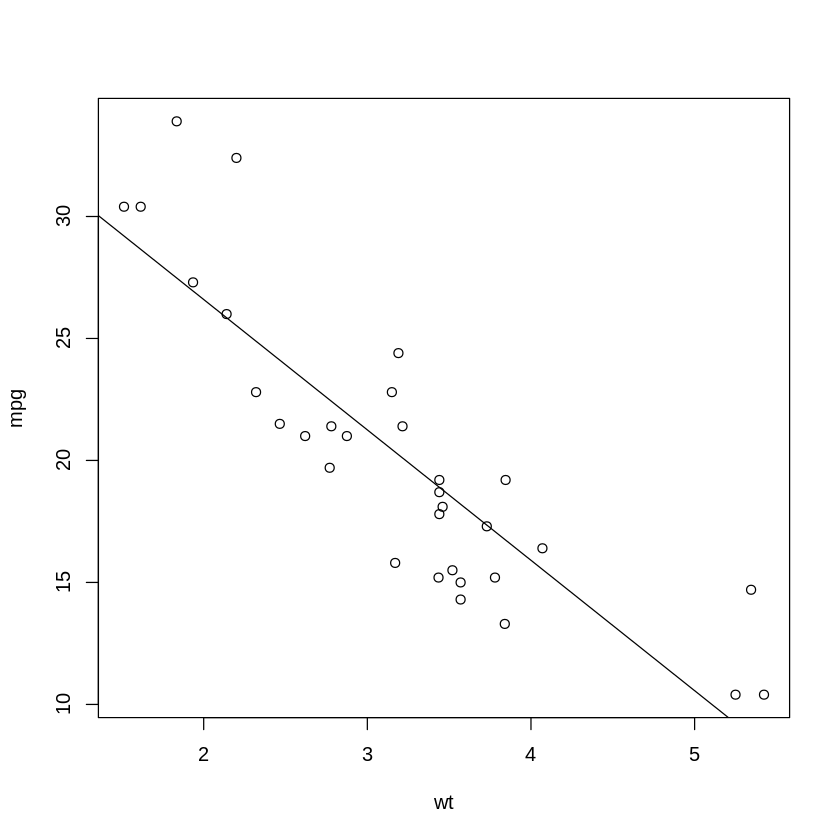

In [10]:
attach(mtcars)
reg = lm( mpg ~ wt )
plot(wt, mpg)
abline(reg)

We will focus on **residual plots**.
- Residuals vs Fitted: see the yhat vs ei. A strong pattern indicates non-linearity in the data.
- Normal QQ: drawing up the data to check whether or not they follow a normal distribution.
- Scale-Location: testing the variance is constant or not. The ideal case is the data points along with the horizontal line.
- Residual vs Leverage: finding the influantial observations on this plot. The data point is above the dust line, which means that it would probably be an influential point.







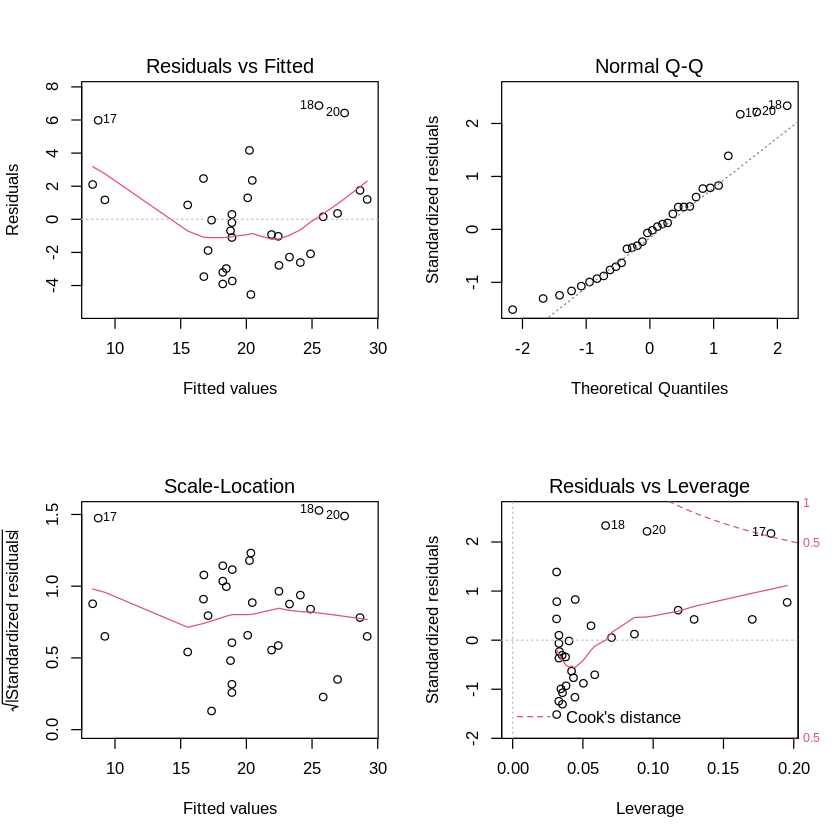

In [11]:
par(mfrow = c(2, 2)) # Return to the 2x2 plot window
plot(reg)

## Studentized residuals and testing for outliers
Based on the Residuals vs Leverage plot above, we should focus on the influential outliers. That is, |rstudent(reg)| > 2.

1           2           3           4           5           6 
-0.76076977 -0.30274050 -0.69972329  0.42681176 -0.06570059 -0.22779587 
          7           8           9          10          11          12 
-1.32167204  1.41169344  0.77876838  0.09844187 -0.36192838  0.28837628 
         13          14          15          16          17          18 
-0.01655496 -0.62515414  0.41709709  0.76444774  2.32816206  2.53780106 
         19          20          21          22          23          24 
 0.60385911  2.38384376 -0.87622897 -0.99290217 -1.25610443 -1.16991451 
         25          26          27          28          29          30 
 0.82326228  0.12041613  0.05090396  0.41668241 -1.55056010 -0.92873434 
         31          32 
-1.07426703 -0.33877056

17       18       20 
2.328162 2.537801 2.383844

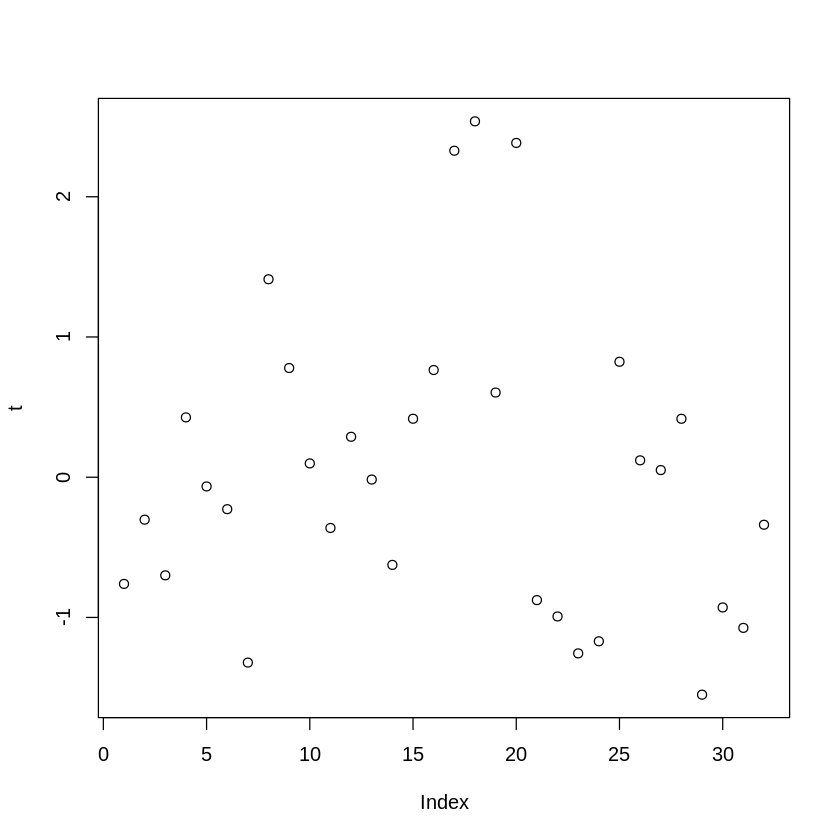

In [12]:
t = rstudent(reg) # Studentized residuals
t
par(mfrow=c(1,1)) # Return to the 1x1 plot window
plot(t) # See if there are any nonlinear trends
t[abs(t)>2]

## Compare with the Bonferroni-adjusted quantile from t-distribution.
The test revealed no outliers.


In [13]:
n = length(wt) # 32 observations
n 
qt( 0.025/n, n-2 ) # degrees of freedom is n-2
t[ abs(t) > abs(qt( 0.025/n, n-2 )) ]

[1] 32

[1] -3.478736

named numeric(0)

## Testing Normality using Shapiro-Wilk normality test
- Normal QQ-plot and Shapiro-Wilk normality test is both a good method to check the normality. 
- With the small p-value 0.03711, we have evidence to reject the null (H0: data is normal distrnuted), meaning that the data tested are not normality.
- W measures how close the graph is to a straight line.

In [14]:
shapiro.test(t)


	Shapiro-Wilk normality test

data:  t
W = 0.92916, p-value = 0.03711


# Testing HOMOSCEDASTICITY (constant variance)
Look at the residual plots including a plot of t^2 vs fitted values\
Below is the Breausch-Pagan test, and it is included in R package called “car”.

- ncvTest: Computes a score test of the hypothesis of constant error variance against the alternative that the error variance changes with the level of the response (fitted values), or with a linear combination of predictors.

Reference: https://cran.r-project.org/web/packages/car/index.html

In [15]:
#-------------------------------------------------------------------------------
# Revision history:
# 2009-09-28 by J. Fox (renamed)
# 2012-07-01 Rewritten by S. Weisberg.  The 'data' argument is now gone
# 2013-07-09 Works correctly if data arg is not set in the model
#            works correctly if the formula in 'lm' is an argument
# 2014-11-06 Fixed conflicts with objects in base package. J. Fox
# 2018-06-07 format p-value. J. Fox
#-------------------------------------------------------------------------------

# score test of nonconstant variance (J. Fox)

ncvTest <- function(model, ...){
    UseMethod("ncvTest")
}

ncvTest.lm <- function(model, var.formula, ...) {
    data <- getCall(model)$data
    model <- if (!is.null(data)){
        data <- eval(data, envir=environment(formula(model)))
        update(model, formula(model), na.action="na.exclude", data=data)
    }
    else update(model, formula(model), na.action="na.exclude")
    sumry <- summary(model)
    residuals <- residuals(model, type="pearson")
    S.sq <- df.residual(model)*(sumry$sigma)^2/sum(!is.na(residuals))
    .U <- (residuals^2)/S.sq
    if (missing(var.formula)) {
        mod <- lm(.U ~ fitted.values(model))
        varnames <- "fitted.values"
        var.formula <- ~ fitted.values
        df <- 1
    }
    else {
        form <- as.formula(paste(".U ~ ", as.character(var.formula)[[2]], sep=""))
        mod <- if(!is.null(data)){
            data$.U <- .U
            lm(form, data=data)
        }  
        else lm(form)
        df <- sum(!is.na(coefficients(mod))) - 1
    }	    
    SS <- anova(mod)$"Sum Sq"
    RegSS <- sum(SS) - SS[length(SS)]
    Chisq <- RegSS/2
    result <- list(formula=var.formula, formula.name="Variance", ChiSquare=Chisq, Df=df, 
        p=pchisq(Chisq, df, lower.tail=FALSE), test="Non-constant Variance Score Test")
    class(result) <- "chisqTest"
    result
}  

ncvTest.glm <- function(model, ...){
    stop("requires lm object")
}

print.chisqTest <- function(x, digits=getOption("digits"), ...){
    title <- if (!is.null(x$test)) x$test else "Chisquare Test"
    cat(title,"\n")
    if (!is.null(x$formula)) cat(x$formula.name, 
        "formula:", as.character(x$formula), "\n")
    cat(paste0("Chisquare = ", format(x$ChiSquare, digits=digits), ", Df = ", x$Df,
        ", p = ", format.pval(x$p, digits=max(1, digits - 2)), "\n"))
    invisible(x)
}


- If p-value <= $\alpha$, which means Homo. is rejected in favor of Heter. is assumed.
- p = 0.84556 indicates we fail to reject the null, meaning that data tested the constant variance.

In [17]:
ncvTest(reg)

Non-constant Variance Score Test 
Variance formula: ~ fitted.values 
Chisquare = 0.03794177, Df = 1, p = 0.84556

## This package also has a built-in outlier test


In [18]:
#-------------------------------------------------------------------------------
# Revision history:
# 2009-09-28 by J. Fox (renamed)
# 2010-04-14 by J. Fox fixed error in reporting largest abs rstudent
# 2012-12-12 by J. Fox fixed handling of labels argument
# 2019-01-02 by J. Fox added lmerMod method
# 2019-05-12 by J. Fox fixed spelling of "Bonferroni"
#-------------------------------------------------------------------------------

# Bonferroni test for an outlier (J. Fox)

outlierTest <- function(model, ...){
	UseMethod("outlierTest")
}

outlierTest.lm <- function(model, cutoff=0.05, n.max=10, order=TRUE, labels=names(rstudent), ...){
	rstudent <- rstudent(model)
	if (length(rstudent) != length(labels))
		stop("Number of labels does not correspond to number of residuals.")
    else names(rstudent) <- labels
	df <- df.residual(model) - 1
	rstudent <- rstudent[!is.na(rstudent)]
	n <- length(rstudent)
	p <- if (class(model)[1] == "glm")
			2*(pnorm(abs(rstudent), lower.tail=FALSE))
		else 2*(pt(abs(rstudent), df, lower.tail=FALSE))
	bp <- n*p
	ord <- if (order) order(bp) else 1:n
	ord <- ord[bp[ord] <= cutoff]
	result <- if (length(ord) == 0){
			which <- which.max(abs(rstudent))
			list(rstudent=rstudent[which], p=p[which], bonf.p=bp[which], signif=FALSE, cutoff=cutoff)
		}
		else {
			if (length(ord) > n.max) ord <- ord[1:n.max]
			result <- list(rstudent=rstudent[ord], p=p[ord], bonf.p=bp[ord], signif=TRUE, cutoff=cutoff)
		}
	class(result)<-"outlierTest"
	result
}

outlierTest.lmerMod <- function(model, ...){
  outlierTest.lm(model, ...)
}

print.outlierTest<-function(x, digits=5, ...){
	if (!x$signif){
		cat("No Studentized residuals with Bonferroni p <", x$cutoff)
		cat("\nLargest |rstudent|:\n")
	}
	bp <- x$bonf
	bp[bp > 1] <- NA
	table <- data.frame(rstudent=x$rstudent,
		"unadjusted p-value"=signif(x$p, digits), "Bonferroni p"=signif(bp, digits),
		check.names=FALSE)
	rownames(table) <- names(x$rstudent)
	print(table)
	invisible(x)
}

The p-value 0.016788 indicates no outliers.

In [20]:
outlierTest(reg)

No Studentized residuals with Bonferroni p < 0.05
Largest |rstudent|:
   rstudent unadjusted p-value Bonferroni p
18 2.537801           0.016788       0.5372

# LACK OF FIT TEST
## The ToothGrowth dataset has only 3 different values of X = dose
- The response is the length of odontoblasts (cells responsible for tooth growth) in 60 guinea pigs. Each animal received one of three dose levels of vitamin C (0.5, 1, and 2 mg/day) by one of two delivery methods, orange juice or ascorbic acid (a form of vitamin C and coded as VC).
- A data frame with 60 observations on 3 variables.



In [29]:
attach(ToothGrowth)
names(ToothGrowth)
head(ToothGrowth)
table(dose) # the only values that dose takes

The following objects are masked from ToothGrowth (pos = 3):

    dose, len, supp


The following objects are masked from ToothGrowth (pos = 4):

    dose, len, supp


The following objects are masked from ToothGrowth (pos = 5):

    dose, len, supp


The following objects are masked from ToothGrowth (pos = 6):

    dose, len, supp


The following objects are masked from ToothGrowth (pos = 7):

    dose, len, supp


The following objects are masked from ToothGrowth (pos = 8):

    dose, len, supp




[1] "len"  "supp" "dose"

,len,supp,dose
,<dbl>,<fct>,<dbl>
1,4.2,VC,0.5
2,11.5,VC,0.5
3,7.3,VC,0.5
4,5.8,VC,0.5
5,6.4,VC,0.5
6,10.0,VC,0.5


dose
0.5   1   2 
 20  20  20 

- Fit two regression models:
- reduced = simple linear regression predicting Y = length in terms of X = dose
- full = using group means to predict Y for each value of X, thus treating X as a categorical variable


Call:
lm(formula = len ~ dose)

Residuals:
    Min      1Q  Median      3Q     Max 
-8.4496 -2.7406 -0.7452  2.8344 10.1139 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   7.4225     1.2601    5.89 2.06e-07 ***
dose          9.7636     0.9525   10.25 1.23e-14 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 4.601 on 58 degrees of freedom
Multiple R-squared:  0.6443,	Adjusted R-squared:  0.6382 
F-statistic: 105.1 on 1 and 58 DF,  p-value: 1.233e-14



Call:
lm(formula = len ~ as.factor(dose))

Residuals:
    Min      1Q  Median      3Q     Max 
-7.6000 -3.2350 -0.6025  3.3250 10.8950 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)       10.6050     0.9486  11.180 5.39e-16 ***
as.factor(dose)1   9.1300     1.3415   6.806 6.70e-09 ***
as.factor(dose)2  15.4950     1.3415  11.551  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 4.242 on 57 degrees of freedom
Multiple R-squared:  0.7029,	Adjusted R-squared:  0.6924 
F-statistic: 67.42 on 2 and 57 DF,  p-value: 9.533e-16


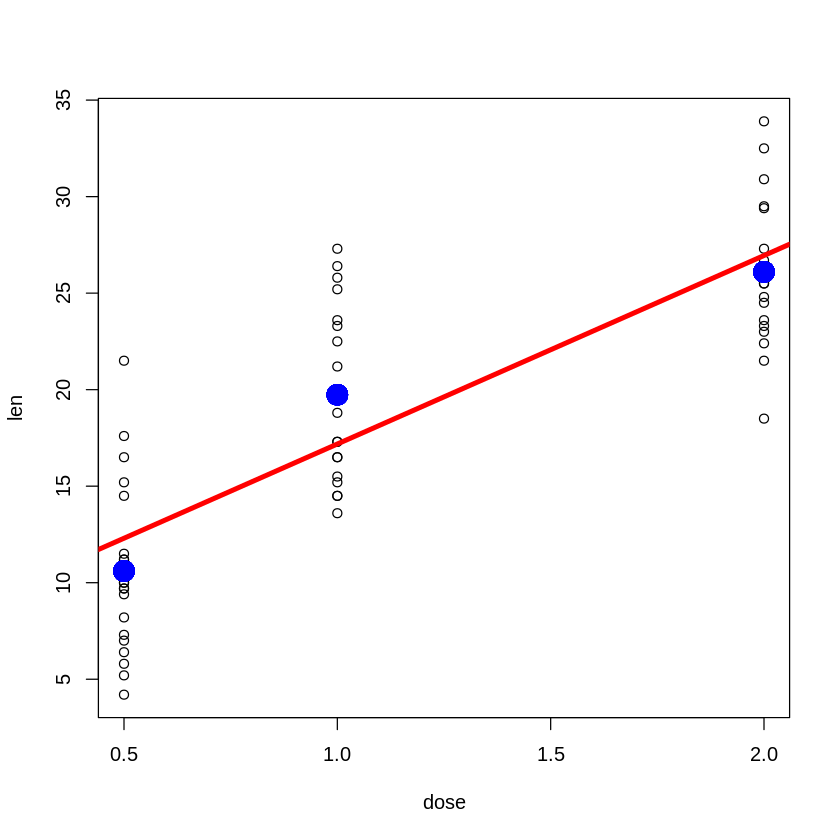

In [33]:
reduced = lm(len ~ dose) # assume linearity, 
full = lm(len ~ as.factor(dose)) # the model does NOT assume linearity
summary(reduced)
summary(full)
plot(dose, len)
abline(reduced,col="red",lwd=4)
points(dose, predict(full), col="blue", lwd=10) # predicted the values using the full model

## Here is the rigorous F-test for the lack of fit
- RSS is SSR
- Model 1 is linear, and Model 2 is non-linear model
- If the p-value is less than critical value, meaning that the relation between x and y is not linear.
- The non-linear (full) model therefore is better since the p-value is small. Conversely, there is a lack of fit in the linear regression model.

In [34]:
 anova(reduced, full) # two anova tables

,Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,58,1227.905,NA,NA,NA,NA
2,57,1025.775,1,202.13,11.23191,0.001432177


# Box-Cox Transformation
- Find the best power transformation of responses that fixes non-normality.
- Make the data following a normal distribution.
- Before we run the regression model, we need to check the data are following a normal distribution. However, with p-value = 0.03711, which means the data tested are not normality.

In [2]:
attach(mtcars)
# Fit a linear regression model, save studentized residuals, and test their Normal distribution
reg = lm( mpg ~ wt )
t = rstudent(reg)
shapiro.test(t)

The following objects are masked from mtcars (pos = 3):

    am, carb, cyl, disp, drat, gear, hp, mpg, qsec, vs, wt





	Shapiro-Wilk normality test

data:  t
W = 0.92916, p-value = 0.03711


We need to focus on "the largest Y-value" mapping to the X position. Thus, the optimal lambda is somewhere between -1 to 0. Then, we zoom in the -1:0 domain.

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



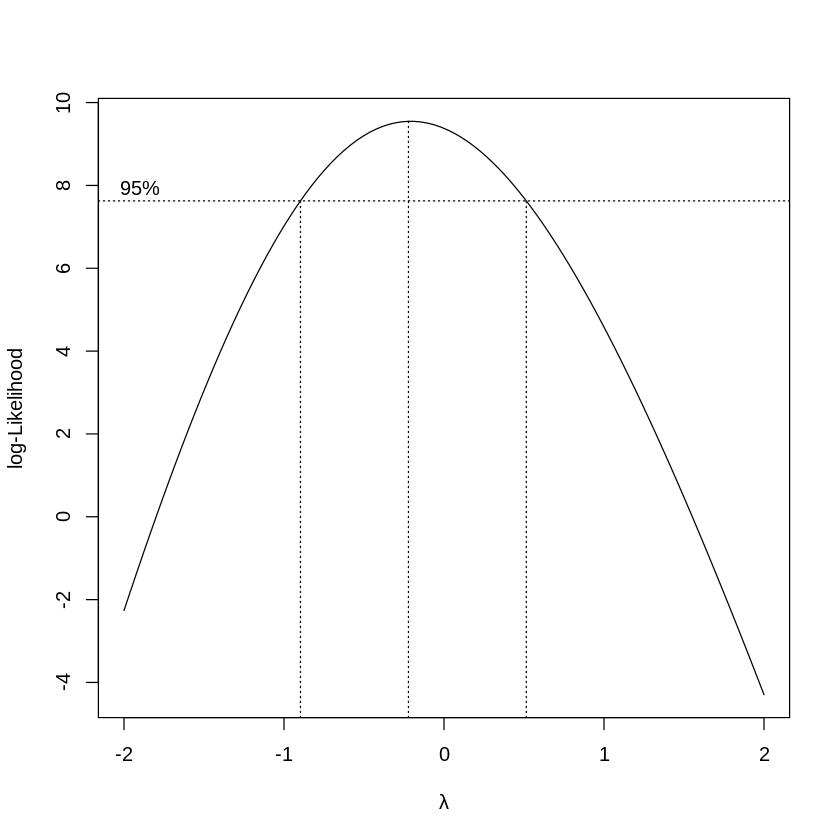

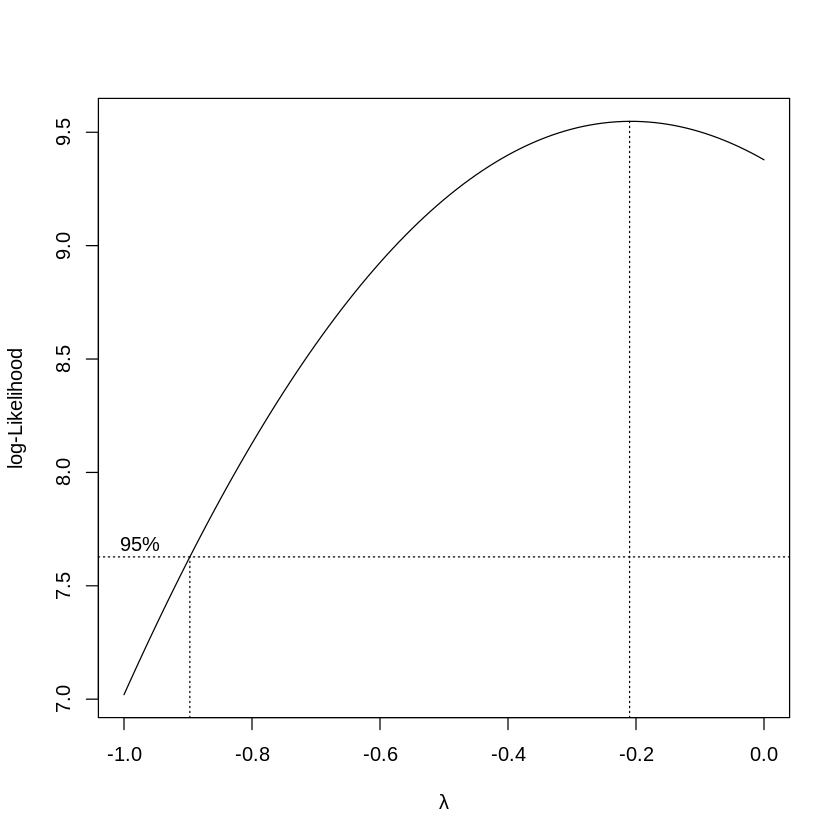

In [4]:
# Results are marginal, so let’s look for the best transformation. Box-Cox is available in package “MASS”
install.packages("MASS")
library(MASS)
boxcox(reg)
boxcox(reg,lambda=seq(-1,0,0.01))

We can see that the best lambda is very close to -0.2 on x-axis (the peak spot). The next step is we check residuals for normality.

- consider changing lm(y~x) to lm(y^lambda ~ x) to met the normality.

In [8]:
Z = mpg^(-2)
newreg = lm(Z ~ wt)
t = rstudent(newreg)
shapiro.test(t)

# optimal lambda
Z = mpg^(-0.2)
newreg = lm(Z ~ wt)
t = rstudent(newreg)
shapiro.test(t)


	Shapiro-Wilk normality test

data:  t
W = 0.97259, p-value = 0.5736



	Shapiro-Wilk normality test

data:  t
W = 0.95892, p-value = 0.2566


According to the second table (Z = mpg^(-0.2)), the p-value is greater than $\alpha$ on new response variable z, meaning that the model passed the "challenge of normality".
